# Historical Weather Data Collection via API Scraping
### Author: Basel Al-Dwairi

This notebook is responsible for collecting hourly historical weather data from an external weather API over multiple years.

The scraped data serves as the raw input for all subsequent preprocessing, feature engineering, and time series modeling tasks.

##### API is from www.wunderground.com

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import sys

##### Python Library Imports:
##### Important Notes:
- requests, bs4, and json: API calls and response parsing
- numpy: Numerical operations
- pandas: DataFrame operations and saving data
- tqdm: Progress bar for loops
- sys: Memory usage checks

In [9]:
date = '20220110'

In [10]:
re = requests.get(f'https://api.weather.com/v1/location/OJAM:9:JO/observations/historical.json?apiKey=e1f10a1e78da46f5b10a1e78da96f525&units=e&startDate={date}')

In [11]:
json_data = json.loads(re.text)

##### Initial Testing of API and JSON Parsing
- Verified connectivity with the Weather API
- Ensured correct JSON response structure

In [44]:
def get_weather_for(year, month, day):

    month = f'0{month}' if month < 10 else month
    day = f'0{day}' if day < 10 else day
    
    date = f'{year}{month}{day}'
    
    response = requests.get(f'https://api.weather.com/v1/location/OJAM:9:JO/observations/historical.json?apiKey=e1f10a1e78da46f5b10a1e78da96f525&units=e&startDate={date}')
    json_data = json.loads(response.text)

    # print(json_data)
    if json_data['metadata']['status_code'] != 200:
        return None

    num_observations = len(json_data['observations'])

    temp_records = []
    dewPt_records = []
    humidity_records = []
    wind_direction_records = []
    wind_speed_records = []
    gust_records = []
    pressure_records = []
    condition_records = []

    for i in range(num_observations):
        temp = json_data['observations'][i]['temp']
        dew = json_data['observations'][i]['dewPt']
        humidity = json_data['observations'][i]['rh']
        wind_dir = json_data['observations'][i]['wdir']
        wind_spd = json_data['observations'][i]['wspd']
        gust = json_data['observations'][i]['gust']
        pressure = json_data['observations'][i]['pressure']
        condition = json_data['observations'][i]['wx_phrase']
        
        temp_records.append(temp if temp else 0)
        dewPt_records.append(dew if dew else 0)
        humidity_records.append(humidity if humidity else 0)
        wind_direction_records.append(wind_dir if wind_dir else 0)
        wind_speed_records.append(wind_spd if wind_spd else 0)
        gust_records.append(gust if gust else 0)
        pressure_records.append(pressure if pressure else 0)
        condition_records.append(condition if condition else 0)

    temp_np = np.array(temp_records) 
    dew_np = np.array(dewPt_records)
    wind_dir_np = np.array(wind_direction_records)
    wind_spd_np = np.array(wind_speed_records)
    gust_np = np.array(gust_records)
    pressure_np = np.array(pressure_records)
    condition_np = np.array(condition_records)

    temp_np_celc = (temp_np - 32) * 5 / 9
    dewPt_np_celc = (dew_np - 32) * 5 / 9

    weather_dic = {
        'Date' : date,
        'Temperature' : temp_np_celc,
        'Dew Point' : dewPt_np_celc,
        'Wind Direction' : wind_dir_np,
        'Wind Speed' : wind_spd_np,
        'Gust' : gust_np,
        'Pressure' : pressure_np,
        'Condition' : condition_np,
    }

    return weather_dic
    

    

##### Main Function: get_weather_for(year, month, day)
- Zero-padding: Ensures date is in YYYYMMDD format for the API
- API request: Fetches historical weather data
- Status check: Returns None if request is invalid
- Extract hourly data:
    - Temperature
    - Dew Point
    - Wind Speed and Direction
    - Gust
    - Pressure
    - Condition
- Handle missing values: Defaults to 0 when data is missing
- Unit conversion: Converts temperature and dew point from Fahrenheit to Celsius
- Output: Returns a dictionary containing hourly data for the given day

In [52]:
test_dic = get_weather_for(2025,11,30)

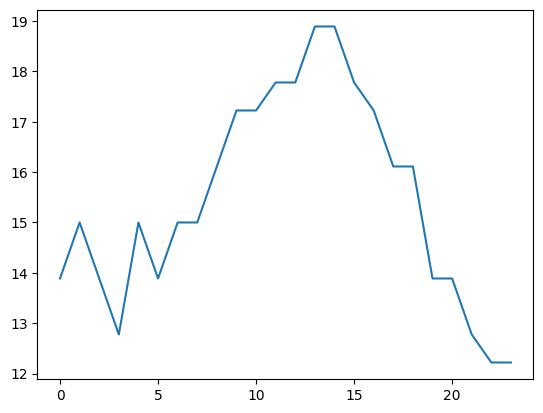

<Figure size 900x1600 with 0 Axes>

In [53]:
if test_dic:
    plt.plot(range(len(test_dic['Temperature'])), test_dic['Temperature'])
    plt.figure(figsize=(9,16))
    plt.show()

###### Testing the Function
- Verified the function works for a single day
- Visualized hourly temperature to ensure correct parsing

In [54]:
def get_valid_dates(year):

    valid_dates = []
    
    for month in range(1, 13):
        max_days_per_month = {
            1 : 31,
            2 : 29 if year % 4 == 0 else 28,
            3 : 31,
            4 : 30,
            5 : 31,
            6 : 30,
            7 : 31,
            8 : 31,
            9 : 30,
            10 : 31,
            11 : 30,
            12 : 31,
        }

        max_days = max_days_per_month[month]

        for day in range(1,max_days + 1): 
            
            date = (year, month, day)
            valid_dates.append(date)

    return valid_dates
    

In [55]:
dates_list = []
for i in range(2010,2026):
    dates = get_valid_dates(i)
    if dates:
        dates_list.append(dates)

In [56]:
dates_row = [i for sub in dates_list for i in sub]

##### Date Generation
- Generates all calendar dates for a given year, accounting for leap years
- Produces a flattened list of all dates across multiple years (2010–2025) for scraping

In [58]:
dates = get_valid_dates(2018)

In [60]:
weather_list = []
for date in tqdm.tqdm(dates_row):
    weather_on_date = get_weather_for(*date)
    weather_list.append(weather_on_date)

100%|████████████████████████████████████████████████████████████| 5844/5844 [1:03:31<00:00,  1.53it/s]


##### Data Collection Loop
- Iterates over all dates and collects daily weather data using get_weather_for
- Sequential process, as this scraping runs only once

In [61]:
sys.getsizeof(weather_list)

47160

In [65]:
weather_list_not_null = [i for i in weather_list if i]

In [67]:
df = pd.DataFrame(weather_list_not_null)

In [68]:
df.to_csv('../data/scraped_weather_2010_2025.csv')

##### Data Cleaning and Saving
- Filters out failed API responses (None)
- Converts list of dictionaries to a pandas DataFrame
- Saves cleaned dataset as CSV for further analysis